### Objective: To Do calculations of descriptors on antibodies with Heparin RTT.
A talented scientist measured Heparin Retention Times (binding to Heparin Column) for various mutants. Its a proxy for clearance of Antibodies in Mice (and humans). 
Below, I computationally mutate and produce the structures of each mutant based on the parent PDB from the EM strucuture. I then use the descriptor pipeline to extract descriptors and plot some scatter plots and correlation plots. 

Note that I change the Heparin RTT value for 'VIRMAB-ML-M190-R2-044' to 1.071.
##### Load some python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from shutil import copy
import matplotlib.pyplot as plt
import nglview as nv
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import numpy as np
import plotly.express as px
from developability.utils import ls, plot_correlogram
from developability.pipeline import run_processing_pipeline
from developability.pdb_tools import extract_fv_from_pdb, extract_sequence_from_pdb

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'



#### Load data files. 

In [2]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

metadata = data_path/'MPK190-v13.csv'
metadata = pd.read_csv(metadata).fillna('').set_index('Name')
metadata_mod = metadata.iloc[6:, :37]

cols =[col for col in metadata_mod.columns if not col.startswith('Un') and  not col.startswith('#')]
metadata_mod =metadata_mod[cols]



##### Write functions for organizing the data. 

In [3]:
def extract_heavy_chain(row): 
    return ''.join([row[str(i)] for i in range(1, 458) if row[str(i)]])

def extract_light_chain(row): 
    cols = [f'{i}.1' for i in range(1,221) ]
    return ''.join([row[col] for col in cols if row[col]])


def get_concensus(seqs):
    counts = {}

    for seq in seqs: 
        for pos, c in enumerate(seq): 
            counts.setdefault(pos+1, {})
            counts[pos+1].setdefault(c, 0)
            counts[pos+1][c]+=1

    concensus = {}
    for pos in counts:
        items = list(counts[pos].items() )
        items.sort(key = lambda x: x[1], reverse=True)
        concensus[pos] = items[0]

    return concensus[0]
        
def get_mutations(child,parent):
    n = min(len(parent), len(child))

    return [[parent[i], i+1, child[i]] for i in range(n) if parent[i]!=child[i]]
    


##### Organize the Heavy and Light Chain FV regions 

In [4]:
metadata_mod['HC']=metadata.apply(extract_heavy_chain, axis = 1)
metadata_mod['LC']=metadata.apply(extract_light_chain, axis = 1)

parent_hc = metadata_mod.loc['VIRMAB-ML-M190-R2-150/1']['HC']
parent_lc = metadata_mod.loc['VIRMAB-ML-M190-R2-150/1']['LC']

metadata_mod['Vh mutations'] = metadata_mod['HC'].apply(lambda x: get_mutations(x, parent_hc))
metadata_mod['Vl mutations'] = metadata_mod['LC'].apply(lambda x: get_mutations(x, parent_lc))

metadata_mod.head()

,Description,RSV A2 IC50 (ng/mL),RSV A2 FC over 1.3,MPV A2 IC50 (ng/mL),MPV A2 FC over 1.3,MPV A2 D280N IC50 (ng/mL),MPV A2 D280N FC over 1.3,MPV F B1 SPR-class,MPV F D280N B1 SPR-class,mean FC,VALD(NAME),Hep RTT,VALD(NAME).1,Tm (deg C),Description.1,VALD(Name),HC,LC,Vh mutations,Vl mutations
Name,,,,,,,,,,,,,,,,,,,,
VIRMAB-ML-M190-R2-150/1,MPK190-v1.3,25.28,1.0,2.1,1.0,2.4,1.0,parent,parent,1.0,VIRMAB-ML-M190-R2-150,1.004,VIRMAB-ML-M190-R2-150,77.9,Control,VIRMAB-ML-M190-R2-150,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,[],[]
VIRMAB-ML-M190-R2-041,Istvan_4cOpt_v2,13.16,1.9,2.6,0.8,0.7,3.6,better than parent,similar to parent,2.1,VIRMAB-ML-M190-R2-041,1.068,VIRMAB-ML-M190-R2-041,83.2,H|23K H|99S L|48L,VIRMAB-ML-M190-R2-041,QVQLVESGGGLVKPGGSLTLSCKASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[A, 23, K], [A, 99, S]]","[[V, 48, L]]"
VIRMAB-ML-M190-R2-101,Istvan_4cOpt_v21_v4.3,15.46,1.6,0.9,2.4,11.6,0.2,similar to parent,similar to parent,1.4,VIRMAB-ML-M190-R2-101,1.08,VIRMAB-ML-M190-R2-101,82.1,H|49S H|77K H|99S L|48L,VIRMAB-ML-M190-R2-101,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[A, 49, S], [M, 64, V], [N, 74, Q], [T, 77, K...","[[V, 48, L]]"
VIRMAB-ML-M190-R2-048,Istvan_4cOpt_v10,15.95,1.6,1.4,1.5,1.4,1.8,better than parent,similar to parent,1.6,VIRMAB-ML-M190-R2-048,1.08,VIRMAB-ML-M190-R2-048,78.2,H|49S H|77K H|101Y L|48L,VIRMAB-ML-M190-R2-048,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"
VIRMAB-ML-M190-R2-026,"L3 mod only, fourth",16.24,1.6,2.4,0.9,458.1,0.0,worse than parent,worse than parent,0.8,VIRMAB-ML-M190-R2-026,0.957,VIRMAB-ML-M190-R2-026,77.7,Rose-L3-4,VIRMAB-ML-M190-R2-026,QVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,[],"[[R, 95, S]]"


In [5]:
parent_pdb = data_path/'MPK190.fv_only.pdb'

output_path = data_path/'MPK190_mutations_v13'
if not output_path.exists(): 
    output_path.mkdir()
    new_parent_pdb = output_path/'MPK190.fv_only.pdb'
    copy(parent_pdb, new_parent_pdb)

new_parent_pdb = output_path/'MPK190.fv_only.pdb'
parent_pdb=new_parent_pdb

#get the seqquences from parent_pdb
seqs=extract_sequence_from_pdb(parent_pdb)
hc_length = len(seqs['H'])
lc_length = len(seqs['L'])
nv.show_structure_file(str(parent_pdb))

NGLWidget()

### Now do calculations for descriptors. 

In this case, I will do the mutate with Openmm as before. 


##### Functions

In [6]:
def mutate_protein(pdb, mutations, output_path=None, output_filename=None, keep_ids=True, transform_mutants=True):
    """Uses PDBFixer to mutate antibody, save the file

    Args:
        pdb (str|path): path to pdb file
        mutations (dict): dict with keys for chain and values of list of mutations
        output_filename (str, optional): name of file. Defaults to None.  
        output_path (str|Path, optional):output path. Defaults to None.
        keep_ids (bool, optional): whether to keep original chain ids and numbering. Defaults to True.
        transform_mutants (bool, optional): If True, transform 1 letter code to 3 letter code. Defaults to True.

    Returns:
        _type_: _description_
    """

    fixer = PDBFixer(str(pdb))
    for chain, muts in mutations.items(): 
        if transform_mutants:
            fixer.applyMutations(transform_mutant_tuples(muts), chain)
        else:
            fixer.applyMutations(muts, chain)
    
    if not output_filename: 
        name = Path(pdb).name.split('.')[0]
        for chain, muts in mutations.items(): 
            if muts: 
                muts = [''.join(str(c) for c in m) for m in muts]
                name += '-' + chain + '-' + '-'.join(muts)
        output_file_name = name + '.pdb'

    if not output_path:
        output_path = Path(pdb).parent
    
    output = output_path /output_file_name
    PDBFile.writeFile(fixer.topology, fixer.positions, open(str(output), 'w'), keepIds = keep_ids)
    return output


def transform_mutant_tuple(mutant):
    return f'{seq3(mutant[0]).upper()}-{int(mutant[1])}-{seq3(mutant[2]).upper()}'

def transform_mutant_tuples(muts): 
    return [transform_mutant_tuple(mut) for mut in muts]

def generate_mutations_dict(row, lc_length, hc_length):
    mutations = {'L': [mutation for mutation in row['Vl mutations'] if mutation[1]<=lc_length],
                 'H': [mutation for mutation in row['Vh mutations'] if mutation[1]<=hc_length]
                 }
    return mutations

In [7]:
descriptors = []
output_path = data_path/'MPK190_mutations_v13'
descriptors_fname = data_path/'MPK190_descriptors_V13_heparin_column.pq'

if not descriptors_fname.exists():
    for i, row in tqdm(enumerate(metadata_mod.iterrows()),total =len(metadata_mod)):
        
        if i==0: 
            input_pdb=parent_pdb

        else:    
            mutations=generate_mutations_dict(row[1], lc_length, hc_length)
            mutant_pdb = mutate_protein(parent_pdb, mutations, data_path/'MPK190_mutations_v13')
            input_pdb = mutant_pdb

        name = input_pdb.name.split('.')[0]
        out_path = output_path/ f'{name}_output'
        
        descriptors.append(run_processing_pipeline(input_pdb=input_pdb, output_path=out_path))

        descriptors_df = pd.concat(descriptors)
    descriptors_df.index = metadata_mod.index
    descriptors_df.to_parquet(descriptors_fname)
else: 
    descriptors_df = pd.read_parquet(descriptors_fname)

descriptors_df.head()

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VIRMAB-ML-M190-R2-150/1,2089.963094,0.0,2089.963094,16287.566702,0.0,16287.566702,3505.332559,-714.676857,2790.655703,21120.968306,0.000000,21120.968306,6347.700416,0.0,6347.700416,21234.057801,0.0,21234.057801,7320.362704,0.0,7320.362704,4009.232890,-1113.853342,2895.379548,3123.085780,-672.847840,2450.237940,5821.971989,0.000000,5821.971989,11546.841395,-368.247983,11178.593412,8036.020448,0.000000,8036.020448,6805.159286,-2518.887181,4286.272104,850.009313,-1882.562124,-1032.552811,21882.862355,-714.676857,21168.185498,12954.290659,-1786.701182,11167.589477,56023.089227,0.000000,56023.089227,27238.030442,-4769.697288,22468.333154,77905.951582,-714.676857,77191.274725,40192.321101,-6556.398470,33635.922630,34837.153014,-2501.378039,32335.774975,83261.119668,-4769.697288,78491.422380,118098.272683,-7271.075327,110827.197355
VIRMAB-ML-M190-R2-041,2485.372372,0.0,2485.372372,17642.078428,0.0,17642.078428,4147.399671,-392.529499,3754.870172,27526.378739,0.000000,27526.378739,6998.809986,0.0,6998.809986,23983.582631,0.0,23983.582631,8217.953102,0.0,8217.953102,4358.487410,-912.654491,3445.832919,3447.845860,-510.811501,2937.034359,6187.762798,0.000000,6187.762798,12283.443351,-282.488574,12000.954777,8856.144003,0.000000,8856.144003,7464.348769,-2083.259531,5381.089238,1021.587399,-1757.076836,-735.489438,24274.850471,-392.529499,23882.320971,13994.096068,-1423.465992,12570.630076,66726.724458,0.000000,66726.724458,29625.523521,-4122.824941,25502.698580,91001.574928,-392.529499,90609.045429,43619.619589,-5546.290933,38073.328656,38268.946538,-1815.995491,36452.951047,96352.247979,-4122.824941,92229.423038,134621.194517,-5938.820432,128682.374085
VIRMAB-ML-M190-R2-101,2912.055676,0.0,2912.055676,18035.122190,0.0,18035.122190,4799.086103,-80.256041,4718.830062,26150.419108,0.000000,26150.419108,7050.335521,0.0,7050.335521,24540.116500,0.0,24540.116500,8008.150987,0.0,8008.150987,4368.147359,-858.182107,3509.965252,3710.669774,-404.623048,3306.046726,6285.817805,0.000000,6285.817805,12452.025784,-263.326864,12188.698921,9092.527986,0.000000,9092.527986,7772.266970,-2051.215780,5721.051189,1047.172595,-1776.434959,-729.262364,25746.263970,-80.256041,25666.007929,14364.634938,-1262.805155,13101.829783,65749.022117,0.000000,65749.022117,30363.993336,-4090.977603,26273.015732,91495.286086,-80.256041,91415.030045,44728.628273,-5353.782758,39374.845515,40110.898908,-1343.061196,38767.837712,96113.015452,-4090.977603,92022.037849,136223.914360,-5434.038799,130789.875561
VIRMAB-ML-M190-R2-048,2828.636942,0.0,2828.636942,17805.114538,0.0,17805.114538,4836.376144,-303.958554,4532.417590,26324.668548,0.000000,26324.668548,6778.018834,0.0,6778.018834,24577.134230,0.0,24577.134230,8110.922331,0.0,8110.922331,4329.160579,-842.001877,3487.158702,3283.219851,-471.120968,2812.098883,6265.488401,0.000000,6265.488401,12292.661915,-280.568631,12012.093284,8780.517336,0.000000,8780.517336,7624.268826,-2

In [8]:
print(f'There are {len(descriptors_df)} antibodies in the dataset.')

There are 69 antibodies in the dataset.


#### Plots

##### Below I plot a heatmap showing the descriptors

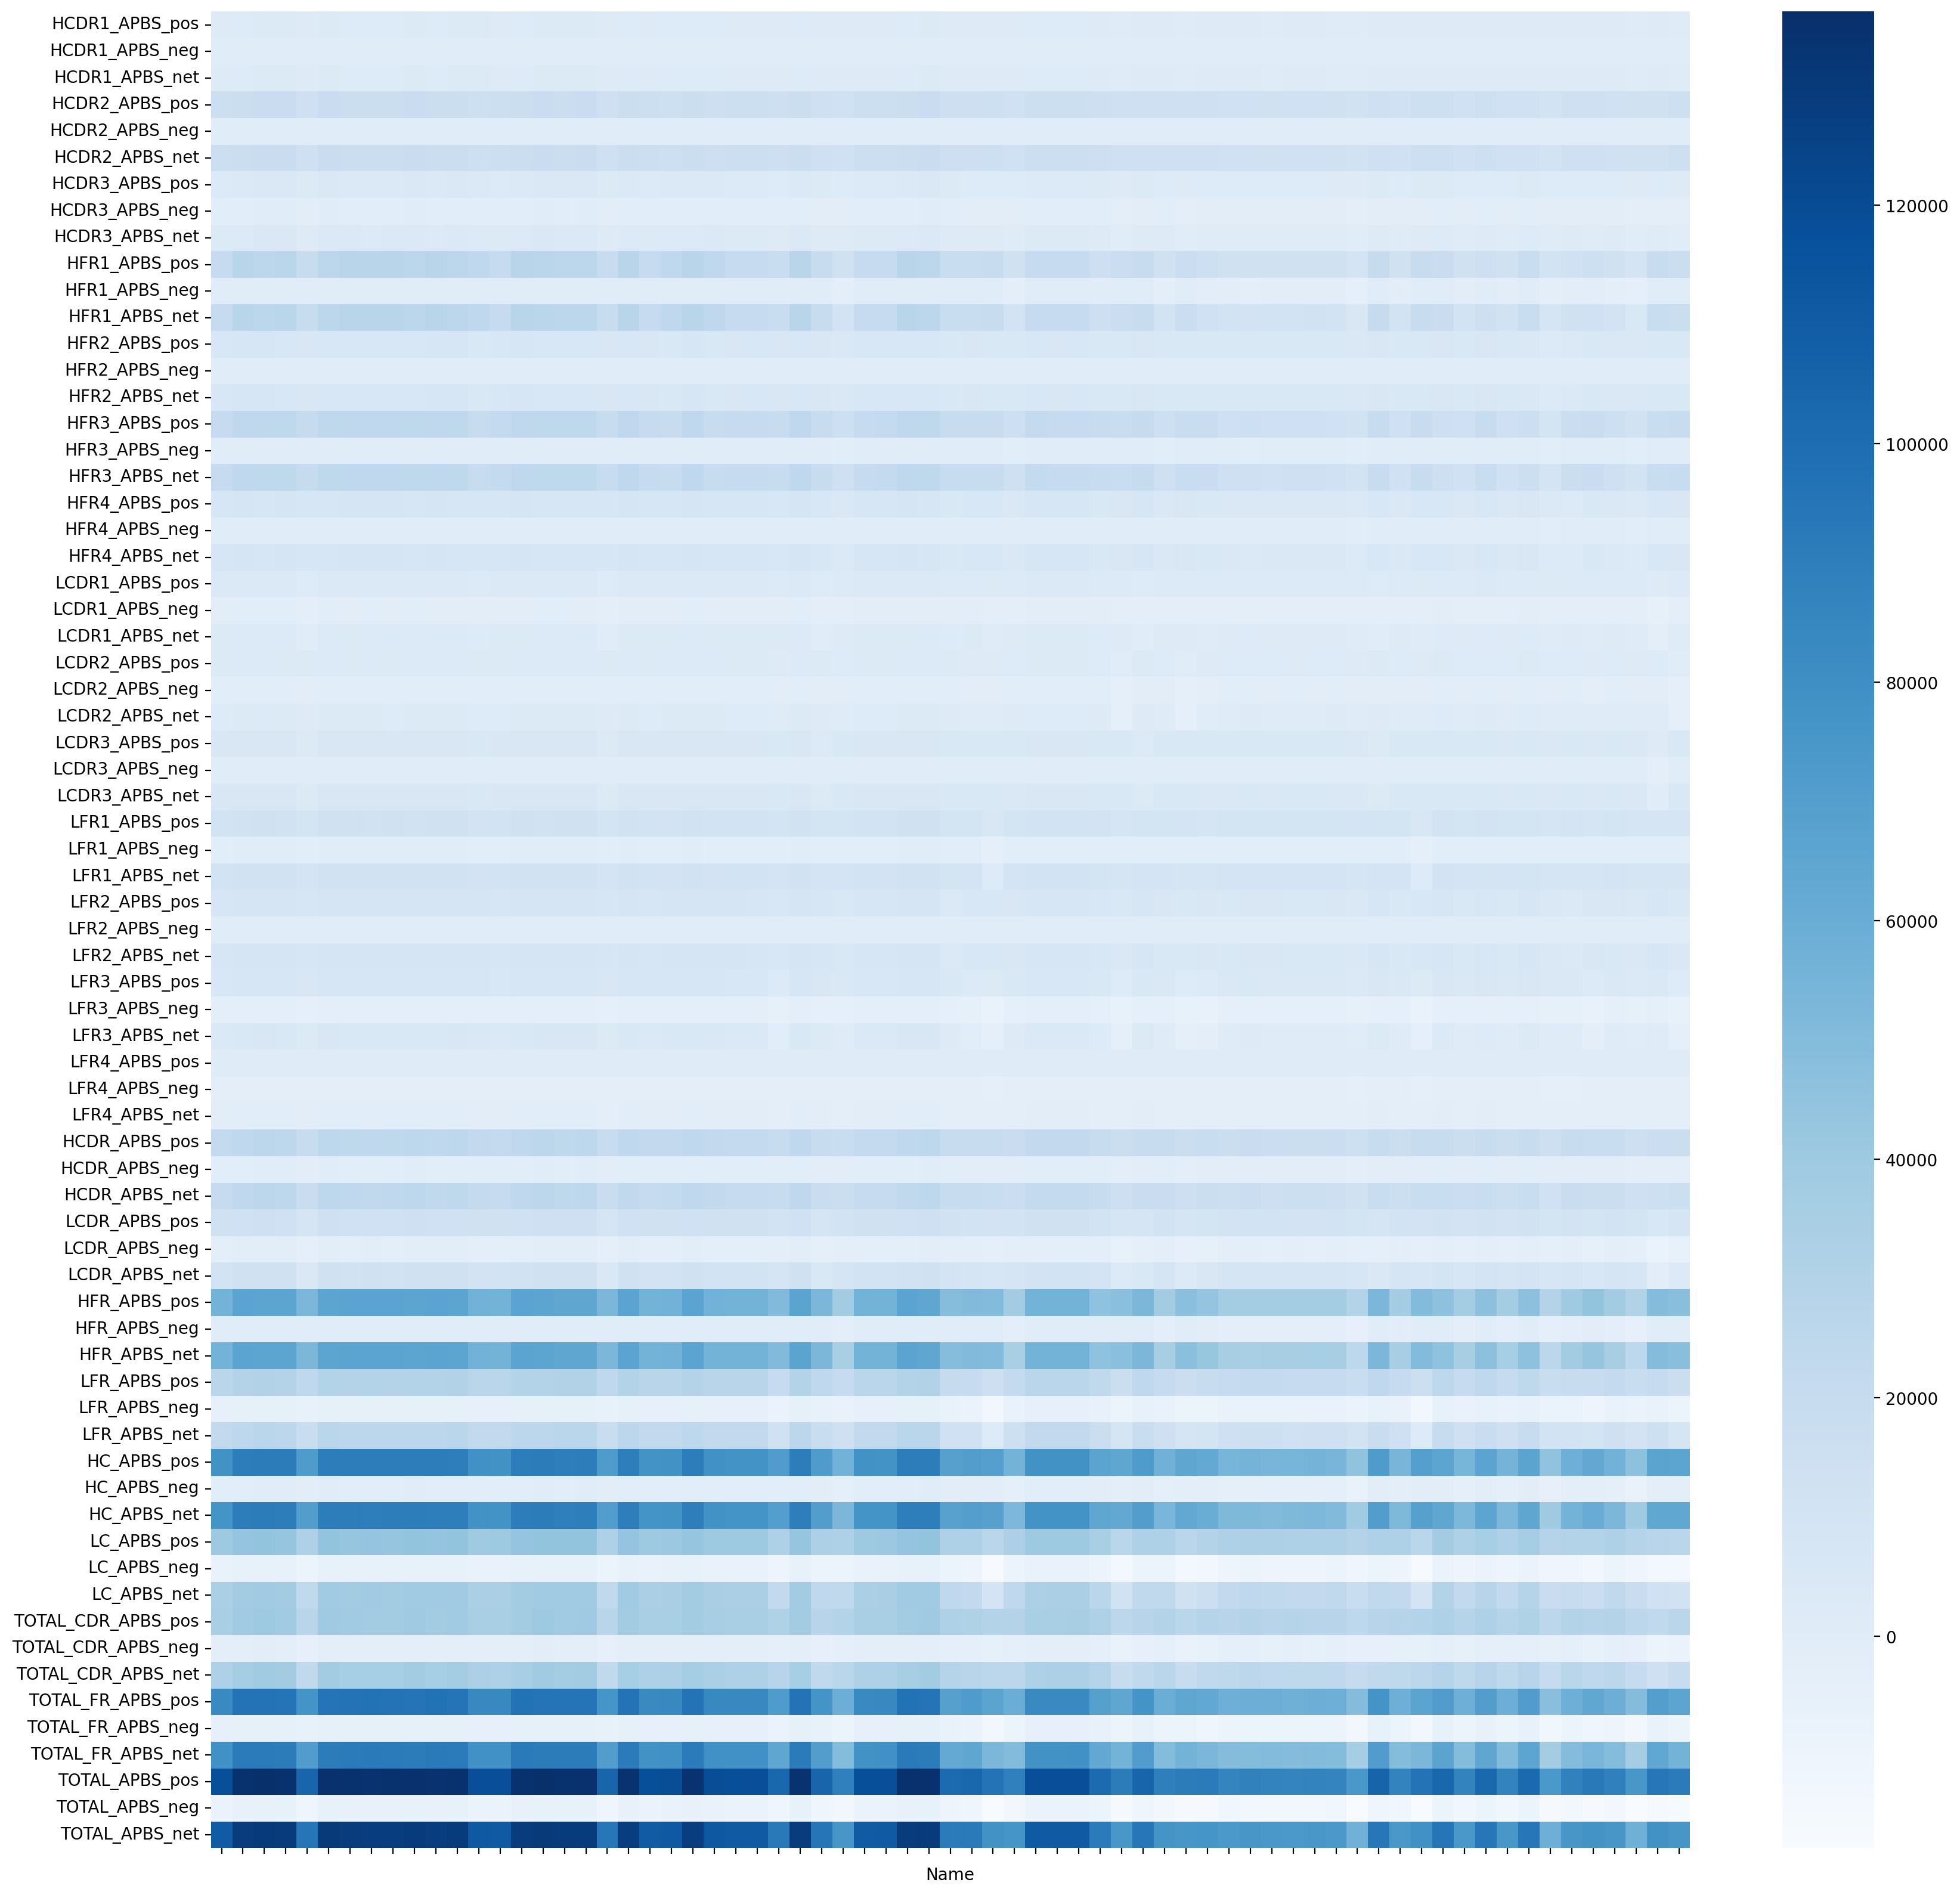

In [9]:
fig,axes = plt.subplots(1,1, figsize = (20,20))
ax= sns.heatmap(descriptors_df.T, cmap = 'Blues', ax = axes)
ax.set(xticklabels = []);

### Remove descriptors that are mostly zeros. 

In [10]:
mean_zeros = (descriptors_df==0).mean()
descriptors_df = descriptors_df[mean_zeros.index[mean_zeros<1]]

#### Correlate with the heparin values 

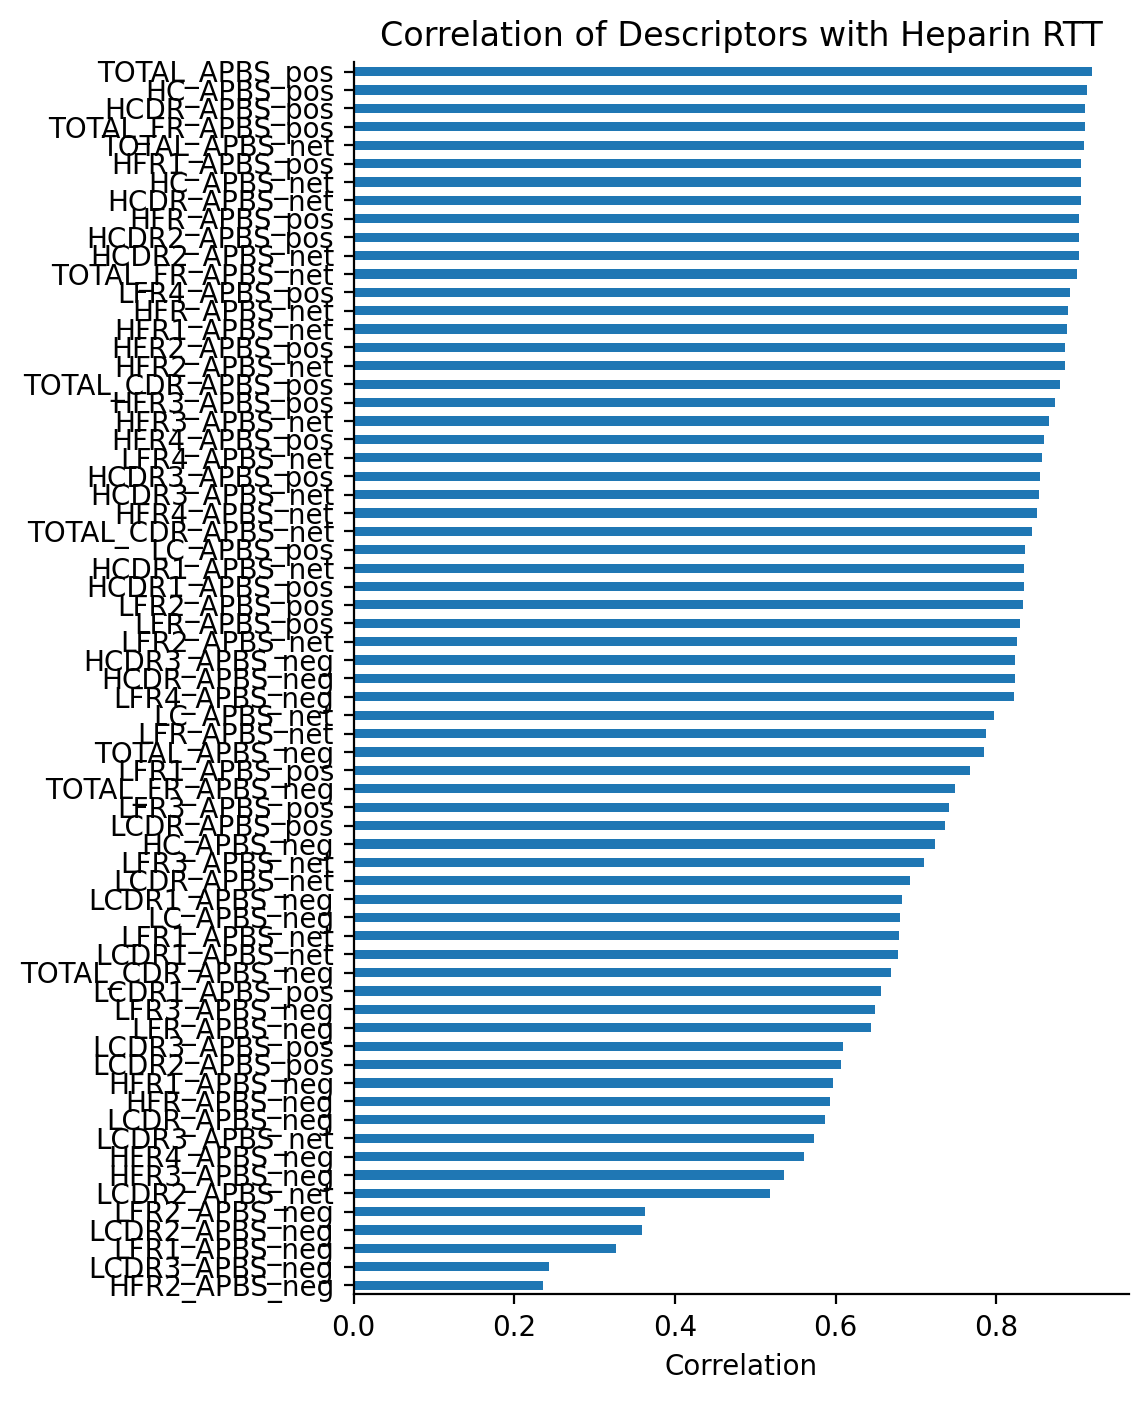

In [11]:
heparin = metadata_mod['Hep RTT'].astype(float)
heparin_corr= descriptors_df.corrwith(heparin).sort_values()

ax = heparin_corr.plot(kind = 'barh', figsize = (5,8))
ax.set(xlabel = 'Correlation', title='Correlation of Descriptors with Heparin RTT')
sns.despine()




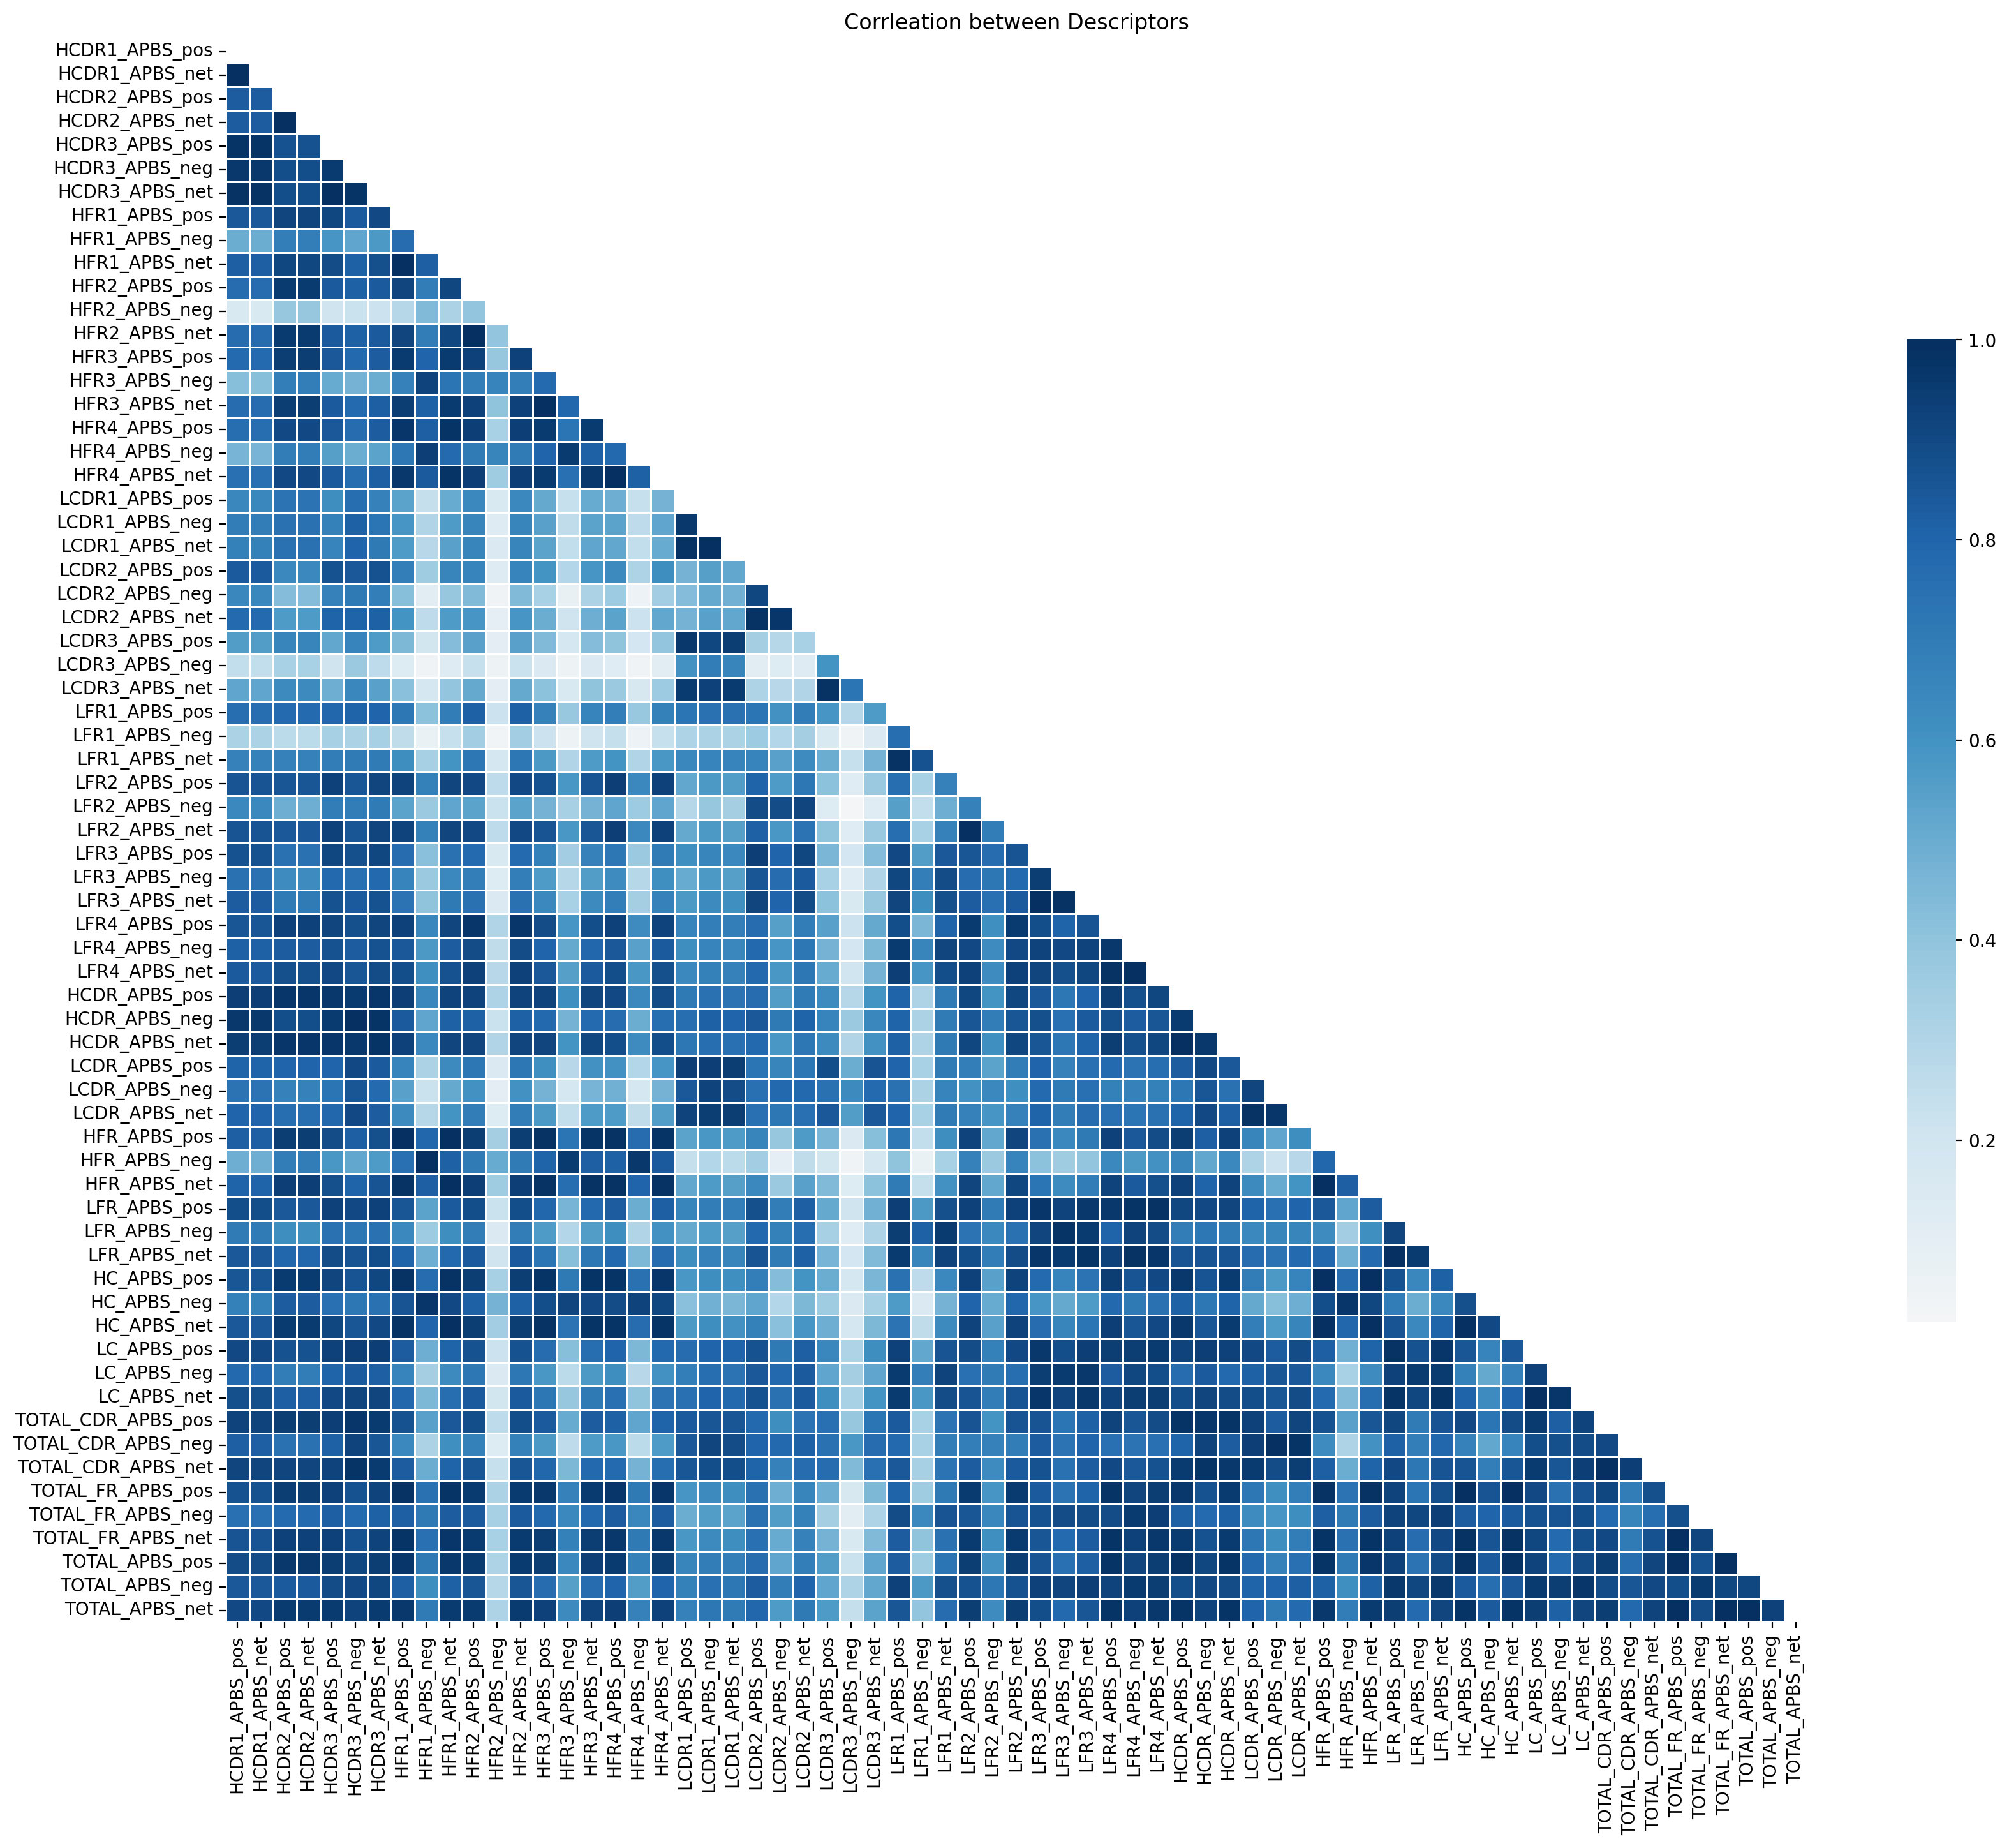

In [12]:
plot_correlogram(descriptors_df, title='Corrleation between Descriptors', cmap='RdBu', figsize=(20,20))

##### Scatter plots for the most relevant descriptors. 

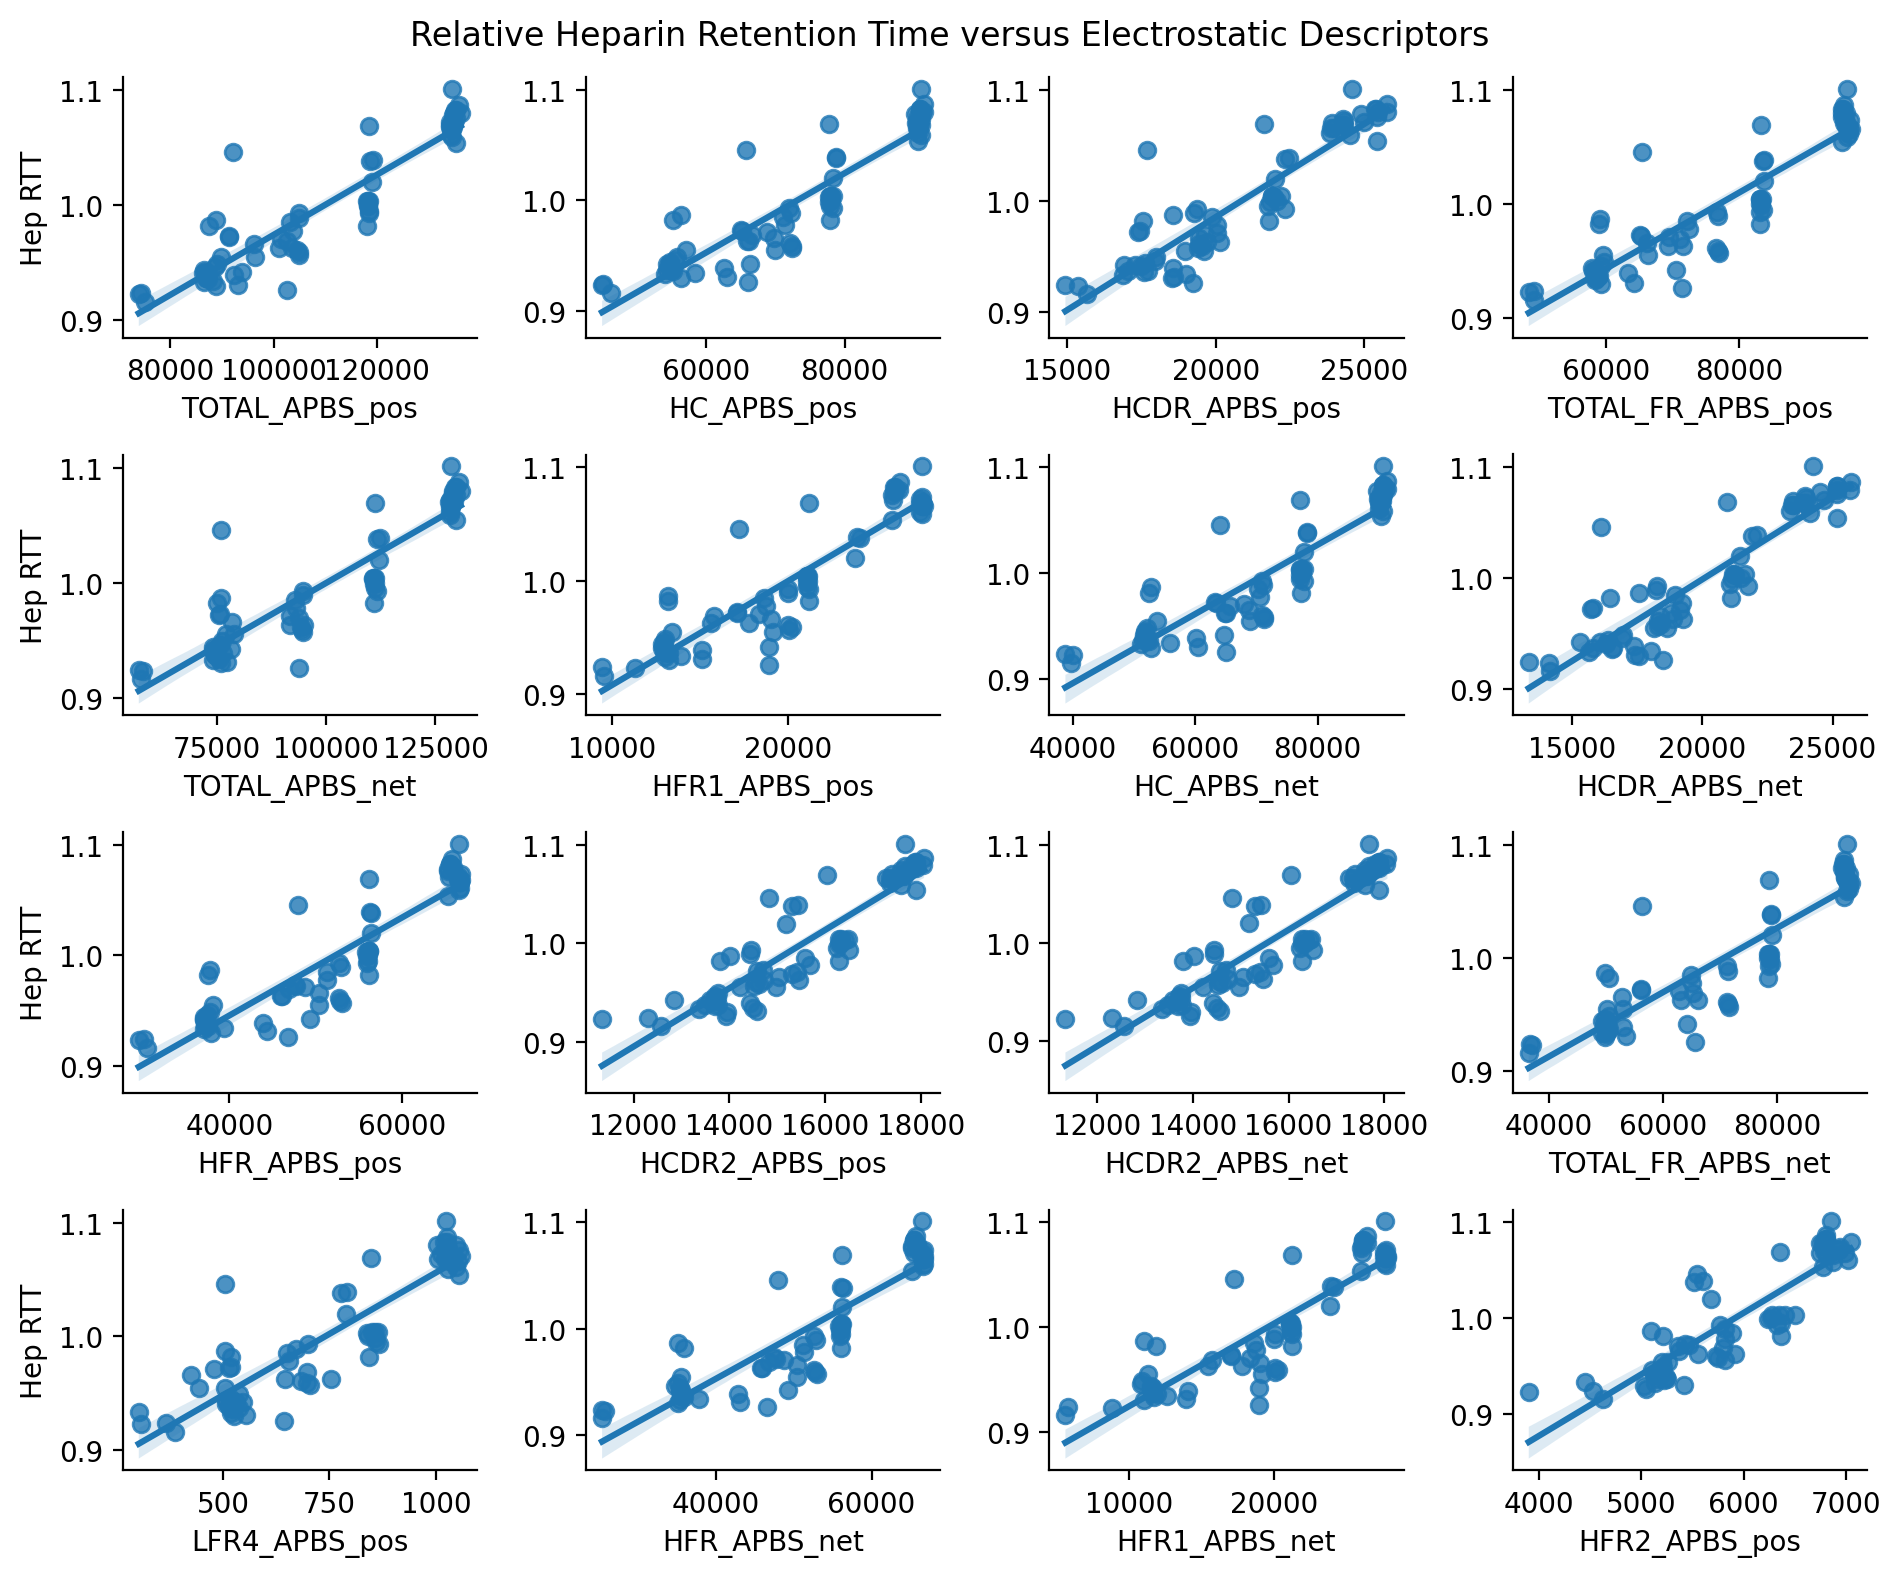

In [13]:
n = 4
height = 2
width = height*1.2

fig, axes = plt.subplots(n,n,figsize =(n*width, n*height))
axes = np.ravel(axes)

cols = heparin_corr.sort_values(ascending = False).index
for i, ax in enumerate(axes): 
    sns.regplot(x = descriptors_df[cols[i]],y = heparin ,ax = ax)
    if i%n==0: 
        ax.set(ylabel = 'Hep RTT', xlabel = cols[i])
    else: 
        ax.set(xlabel = cols[i], ylabel = '')

sns.despine()
fig.suptitle('Relative Heparin Retention Time versus Electrostatic Descriptors')
plt.tight_layout()


##### Save the modified Metadata for later. 

In [14]:
metadata_mod['HC FV']= metadata_mod['HC'].apply(lambda x: x[:hc_length])
metadata_mod['LC FV']= metadata_mod['LC'].apply(lambda x: x[:lc_length])
metadata_mod.drop(['Vh mutations', 'Vl mutations'], axis = 1).to_parquet(data_path/'MPK190-v13-metadata.pq')

In [15]:
heparin_corr.sort_values(ascending=False)

TOTAL_APBS_pos        0.918697
HC_APBS_pos           0.913321
HCDR_APBS_pos         0.910784
TOTAL_FR_APBS_pos     0.910586
TOTAL_APBS_net        0.908747
HFR1_APBS_pos         0.905982
HC_APBS_net           0.905047
HCDR_APBS_net         0.904830
HFR_APBS_pos          0.903008
HCDR2_APBS_pos        0.902665
HCDR2_APBS_net        0.902665
TOTAL_FR_APBS_net     0.900394
LFR4_APBS_pos         0.891927
HFR_APBS_net          0.889730
HFR1_APBS_net         0.887920
HFR2_APBS_pos         0.885738
HFR2_APBS_net         0.885526
TOTAL_CDR_APBS_pos    0.879345
HFR3_APBS_pos         0.873086
HFR3_APBS_net         0.866163
HFR4_APBS_pos         0.858960
LFR4_APBS_net         0.856628
HCDR3_APBS_pos        0.854983
HCDR3_APBS_net        0.853103
HFR4_APBS_net         0.850315
TOTAL_CDR_APBS_net    0.844059
LC_APBS_pos           0.835481
HCDR1_APBS_net        0.834901
HCDR1_APBS_pos        0.834901
LFR2_APBS_pos         0.833353
LFR_APBS_pos          0.829092
LFR2_APBS_net         0.825651
HCDR3_AP

### Look at a subset of the descriptors. 

In [16]:
def should_keep(col): 
    if 'net' not in col: 
        return False
    for num in [1,2,3,4,5]: 
        if str(num) in col: 
            return True
    return False


subset = [col for col in descriptors_df.columns if should_keep(col)] 
subset

['HCDR1_APBS_net',
 'HCDR2_APBS_net',
 'HCDR3_APBS_net',
 'HFR1_APBS_net',
 'HFR2_APBS_net',
 'HFR3_APBS_net',
 'HFR4_APBS_net',
 'LCDR1_APBS_net',
 'LCDR2_APBS_net',
 'LCDR3_APBS_net',
 'LFR1_APBS_net',
 'LFR2_APBS_net',
 'LFR3_APBS_net',
 'LFR4_APBS_net']

In [17]:
descriptors_df.columns

Index(['HCDR1_APBS_pos', 'HCDR1_APBS_net', 'HCDR2_APBS_pos', 'HCDR2_APBS_net',
       'HCDR3_APBS_pos', 'HCDR3_APBS_neg', 'HCDR3_APBS_net', 'HFR1_APBS_pos',
       'HFR1_APBS_neg', 'HFR1_APBS_net', 'HFR2_APBS_pos', 'HFR2_APBS_neg',
       'HFR2_APBS_net', 'HFR3_APBS_pos', 'HFR3_APBS_neg', 'HFR3_APBS_net',
       'HFR4_APBS_pos', 'HFR4_APBS_neg', 'HFR4_APBS_net', 'LCDR1_APBS_pos',
       'LCDR1_APBS_neg', 'LCDR1_APBS_net', 'LCDR2_APBS_pos', 'LCDR2_APBS_neg',
       'LCDR2_APBS_net', 'LCDR3_APBS_pos', 'LCDR3_APBS_neg', 'LCDR3_APBS_net',
       'LFR1_APBS_pos', 'LFR1_APBS_neg', 'LFR1_APBS_net', 'LFR2_APBS_pos',
       'LFR2_APBS_neg', 'LFR2_APBS_net', 'LFR3_APBS_pos', 'LFR3_APBS_neg',
       'LFR3_APBS_net', 'LFR4_APBS_pos', 'LFR4_APBS_neg', 'LFR4_APBS_net',
       'HCDR_APBS_pos', 'HCDR_APBS_neg', 'HCDR_APBS_net', 'LCDR_APBS_pos',
       'LCDR_APBS_neg', 'LCDR_APBS_net', 'HFR_APBS_pos', 'HFR_APBS_neg',
       'HFR_APBS_net', 'LFR_APBS_pos', 'LFR_APBS_neg', 'LFR_APBS_net',
       'HC_APBS

### Remarks: 
We see vast improvement in the quality of prediction using the heparin relative retention time versus heparin binding affinity estimated by ELISA. 
The results are quite nice. 